# CSC6711 Project 4 - Collaborative Filtering with kNN
* **Author:** Jacob Buysse

This notebook is an analysis of the predictions based on user clustering using kNN.
The files are located in the datasets subdirectory:

* MovieLens - `movielens_25m.feather` (Movies)
* Netflix Prize - `netflix_prize.feather` (Movies and TV Shows)
* Yahoo! Music R2 - `yahoo_r2_songs.subsampled.feather` (Songs)
* BoardGameGeek - `boardgamegeek.feather` (Board Games)

We will be using the following libraries:

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.stats import linregress
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import GroupShuffleSplit, train_test_split

Let us configure matplotlib for readable labels, high resolution, and automatic layout.

In [2]:
matplotlib.rc('axes', labelsize=16)
matplotlib.rc('figure', dpi=150, autolayout=True)

## Neighborhood Analysis

The below code has a series of functions for:
* Loading the dataset
* Filtering out users with only one rating
* Splitting the remaining users into training/testing dataframe with a 75/25 split
* Splitting the testing dataframe into a seen/unseen dataframe with a 75/25 split
* Using LabelEncoder to encode user_id -> user_idx and item_id -> item_idx
  * Note that item_idx is unique across both the training and testing dataframes
  * user_idx is unique for training and different but unique for testing
  * The seen/unseen dataframes share the same user_idx values (each user has at least one record in each)
* Create a sparse matrix `train_X` for the testing dataframe (# train users x # items)
* Create a sparse matrix `test_X` for the seen testing dataframe (# test users x # items)
* Test neighborhood size between 5 and 250.  For each:
  * Create a new NearestNeighborhood model seeded with `train_X` sparse matrix and using cosine similarity
  * Find the k nearest neighbors (a set of training user_idx values) from the `test_X` sparse matrix
    * NOTE: This is the slowest step due to the time complexity for kNN for large user sets
  * Melt the result back into a dataframe (multiple training user_idx values for a single testing user_idx)
  * Inner join to the unseen dataframe (this will give you the items we need predictions for)
  * Inner join to the training dataframe (this will find all training records for users in the neighborhood for unseen items)
  * Group by testing user_id and item_id to get the average rating
  * Merge the unseen dataframe back with the averages dataframe
  * Note that this result (known as `all_pred_df`) will include NaN values for any unseen item where nobody in the neighborhood rated it
  * Save this result to disk (originally done to recover from failure, but smart for replay too)
    * NOTE: You can purge the temp directory holding these files to recompute them on subsequent runs
  * Filter out the NaN records and compute the R^2 value using linear regression

In [7]:
def GetCacheFileName(name, k):
    return f"./pred_cache/{name}.pred.v2.k{k}.feather"

def GetCachedPredictions(name, k):
    cached_df = pd.read_feather(GetCacheFileName(name, k))
    print('Using cached result (clear /pred_cache folder to recompute)')
    return cached_df

def LoadOrComputePrediction(name, k, train_X, test_X, unseen_df, train_df):
    try:
        return GetCachedPredictions(name, k)
    except:
        nn = NearestNeighbors(n_neighbors=k, metric='cosine', n_jobs=-1)
        print('Fitting kNN model on training data')
        nn.fit(train_X)
        print('Finding neighbors for "seen" testing data')
        neighbors = nn.kneighbors(test_X, return_distance=False)
        print('Melting neigbors')
        melted_neighbors_df = pd.DataFrame(neighbors).melt(
            value_name='neighbor_train_user_idx',
            ignore_index=False
        )[['neighbor_train_user_idx']].reset_index(names='test_user_idx')
        print('Computing average ratings for the "unseen" testing data')
        merged_df = unseen_df\
            .merge(melted_neighbors_df, left_on='user_idx', right_on='test_user_idx')\
            .merge(train_df, left_on=['neighbor_train_user_idx', 'item_idx'], right_on=['user_idx', 'item_idx'], suffixes=['', '_train'])
        averages_df = merged_df.groupby(['user_idx', 'item_idx'])[['rating_train']].mean()        
        all_pred_df = unseen_df.merge(averages_df, how='left', on=['user_idx', 'item_idx'])\
            [['item_id', 'user_id', 'rating', 'rating_train']]
        print('Saving cached result to disk')
        all_pred_df.to_feather(GetCacheFileName(name, k))
        return all_pred_df    

def ComputeR2(pred_df):
    result = linregress(pred_df.rating, pred_df.rating_train)
    rvalue = result.rvalue
    return rvalue * rvalue
    
def AnalyzeDataset(title, name):
    print(f"Analyzing dataset for {title}")
    df = pd.read_feather(f'./datasets/{name}.feather')
    print(f"Initial dataset: {df.shape}")
    print(f"Original Distinct Users: {df.user_id.nunique()}")
    counts_df = df.groupby('user_id')[['rating']].count()
    merged_df = df.merge(counts_df, on='user_id', suffixes=['', '_count'])
    filtered_df = merged_df[merged_df.rating_count > 1]
    multi_df = filtered_df.copy()
    print(f"Filtering out users with only one rating: {multi_df.shape}")

    item_id_encoder = LabelEncoder()
    item_id_encoder.fit(multi_df.item_id)
    n_items = item_id_encoder.classes_.size
    print(f"Distinct Item Count: {n_items:,}")
    multi_df['item_idx'] = item_id_encoder.transform(multi_df.item_id)

    gss = GroupShuffleSplit(n_splits=1, train_size=0.75, random_state=777)
    train_index, test_index = next(gss.split(X=multi_df, y=multi_df.rating, groups=multi_df.user_id))
    train_df = multi_df.iloc[train_index].copy()
    test_df = multi_df.iloc[test_index].copy()
    print(f"Train {train_df.shape}, Test {test_df.shape}")

    train_user_id_encoder = LabelEncoder()
    train_user_id_encoder.fit(train_df.user_id)
    n_train_users = train_user_id_encoder.classes_.size
    train_df['user_idx'] = train_user_id_encoder.transform(train_df.user_id)
    print(f"Distinct Training Users: {n_train_users:,}")
    
    test_user_id_encoder = LabelEncoder()
    test_user_id_encoder.fit(test_df.user_id)
    n_test_users = test_user_id_encoder.classes_.size
    test_df['user_idx'] = test_user_id_encoder.transform(test_df.user_id)
    print(f"Distinct Testing Users: {n_test_users:,}")
    print(f"Remaining Distinct Users: {n_train_users + n_test_users}")

    train_X = csr_matrix(
        (train_df.rating, (train_df.user_idx, train_df.item_idx)),
        shape=(n_train_users, n_items)
    )

    seen_df, unseen_df = train_test_split(test_df, train_size=0.75, random_state=777, stratify=test_df.user_idx)
    print(f"Seen {seen_df.shape}, Unseen {unseen_df.shape}")

    test_X = csr_matrix(
        (seen_df.rating, (seen_df.user_idx, seen_df.item_idx)),
        shape=(n_test_users, n_items)
    )

    print('')

    for k in [5, 10, 25, 50, 100, 150, 200, 250]:
        print(f"Testing neighborhood size k={k}")
        all_pred_df = LoadOrComputePrediction(name, k, train_X, test_X, unseen_df, train_df)
        pred_df = all_pred_df[all_pred_df.rating_train.notnull()]
        n_total = all_pred_df.shape[0]
        n_pred = pred_df.shape[0]
        n_null = n_total - n_pred
        print(f"Done. Predicted {n_pred} of {n_total} ({n_null} NaN)")
        print(f"Predicted Distinct Users: {pred_df.user_id.nunique()}")

        coef_det = ComputeR2(pred_df)
        print(f"k={k}, R^2 = {coef_det}")
        print('')

Now let us analyze all four datasets using the helper functions.  Note that this will take a few hours on the first run but maybe just a few minutes on subsequent runs thanks to the cache of feather files it produces.

In [8]:
AnalyzeDataset('MovieLens', 'movielens_25m')
AnalyzeDataset('Netflix', 'netflix_prize')
AnalyzeDataset('Yahoo! Music', 'yahoo_r2_songs.subsampled')
AnalyzeDataset('BoardGameGeek', 'boardgamegeek')

Analyzing dataset for MovieLens
Initial dataset: (24890583, 3)
Original Distinct Users: 162541
Filtering out users with only one rating: (24890583, 4)
Distinct Item Count: 24,330
Train (18706943, 5), Test (6183640, 5)
Distinct Training Users: 121,905
Distinct Testing Users: 40,636
Remaining Distinct Users: 162541
Seen (4637730, 6), Unseen (1545910, 6)

Testing neighborhood size k=5
Using cached result (clear /pred_cache folder to recompute)
Done. Predicted 1155346 of 1545910 (390564 NaN)
Predicted Distinct Users: 40010
k=5, R^2 = 0.1495154188384571

Testing neighborhood size k=10
Using cached result (clear /pred_cache folder to recompute)
Done. Predicted 1280716 of 1545910 (265194 NaN)
Predicted Distinct Users: 40368
k=10, R^2 = 0.1710952844882682

Testing neighborhood size k=25
Using cached result (clear /pred_cache folder to recompute)
Done. Predicted 1393835 of 1545910 (152075 NaN)
Predicted Distinct Users: 40559
k=25, R^2 = 0.19837371652315747

Testing neighborhood size k=50
Using 

## Visualizations

Let us define a helper function for graphing the true ratings. vs predictions for the best models.

In [16]:
def PlotRatings(title, name, k, use_bins=False):
    all_pred_df = GetCachedPredictions(name, k)
    pred_df = all_pred_df[all_pred_df.rating_train.notnull()].copy()
    agg_column = 'rating'
    if use_bins:
        agg_column = 'rating_bin'
        pred_df[agg_column] = np.floor(pred_df.rating)
    plot = sns.boxplot(data=pred_df, x=agg_column, y='rating_train')
    plot.set(title=f"{title} (k={k})", xlabel='True Rating', ylabel='Average Neighborhood Rating')
    plt.show()

We will use the k=250 for all models (it was the best in each case).  For BoardGameGeeks, we can use the "floor" of the true rating to show the graph using discrete bins (vs. the original true ratings which are 1.3, for example).

Using cached result (clear /pred_cache folder to recompute)


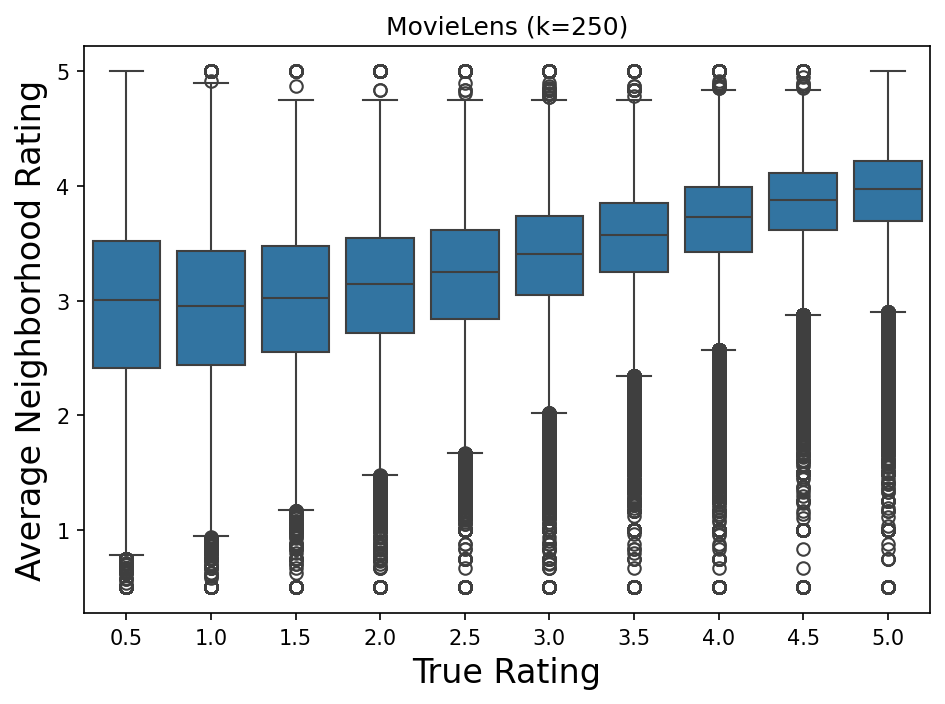

Using cached result (clear /pred_cache folder to recompute)


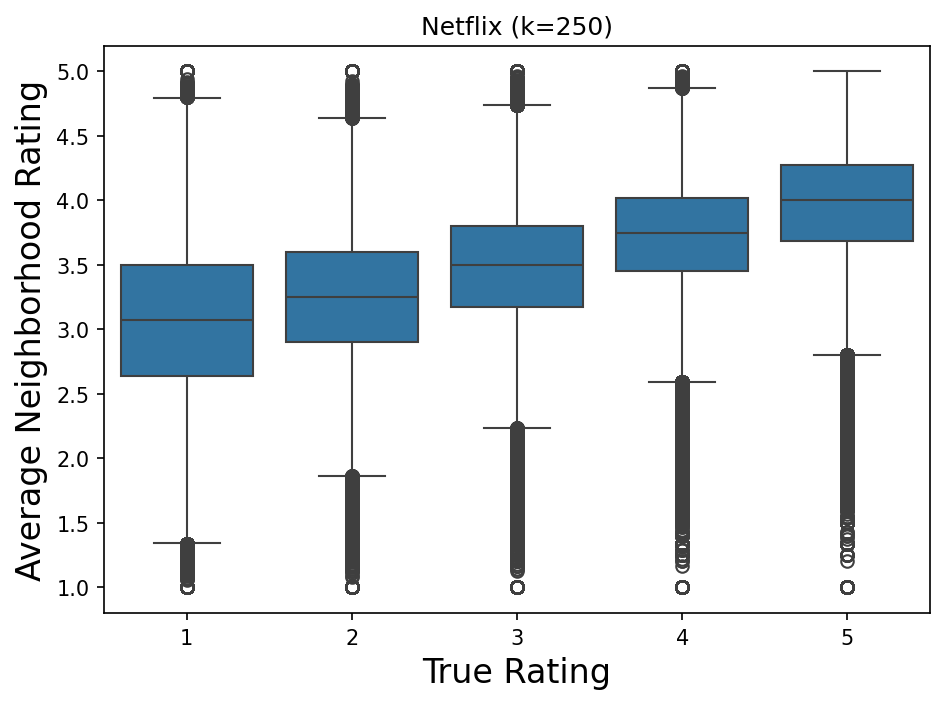

Using cached result (clear /pred_cache folder to recompute)


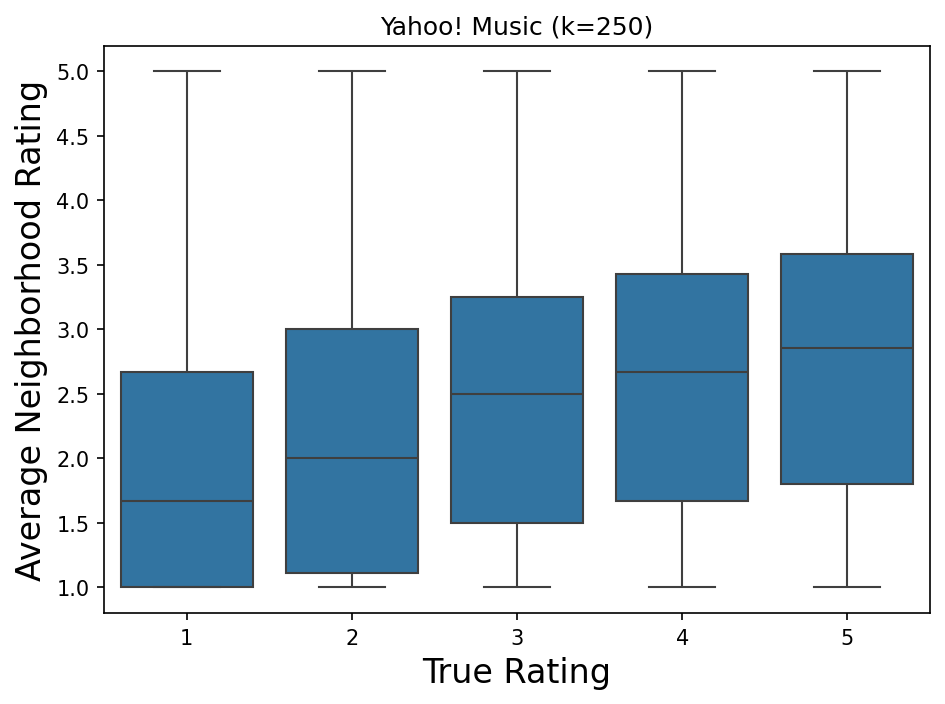

Using cached result (clear /pred_cache folder to recompute)


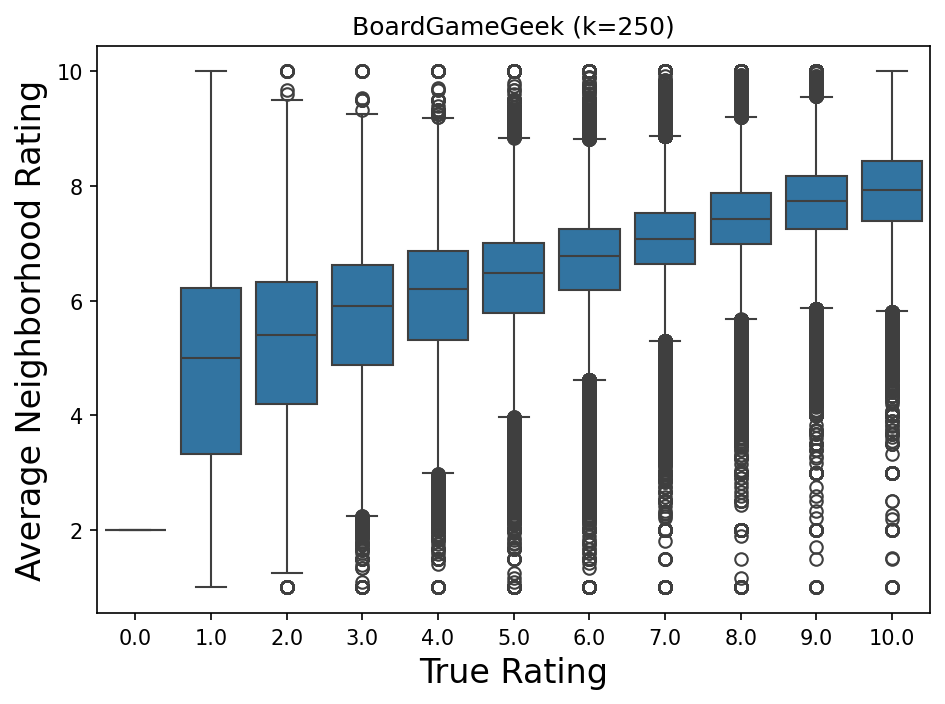

In [17]:
PlotRatings('MovieLens', 'movielens_25m', k=250)
PlotRatings('Netflix', 'netflix_prize', k=250)
PlotRatings('Yahoo! Music', 'yahoo_r2_songs.subsampled', k=250)
PlotRatings('BoardGameGeek', 'boardgamegeek', k=250, use_bins=True)